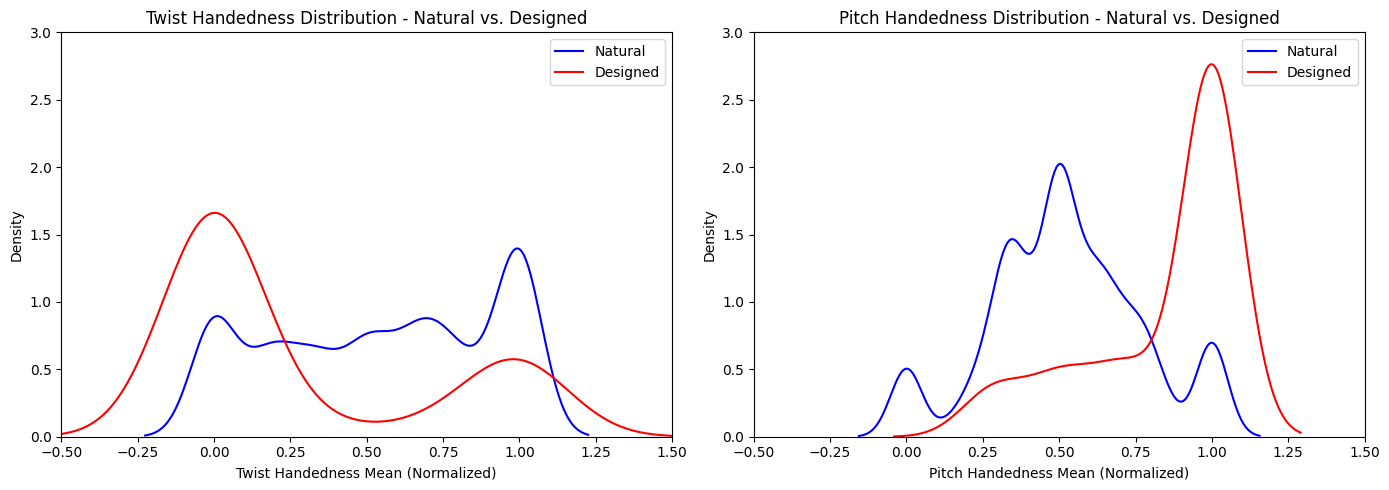

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

#Calculate KDE (Kernel Density Estimate)
# Calculate global min and max for twist_sign_mean and pitch_sign_mean across both datasets
min_twist = min(filtered_natural['twist_mean'].min(), filtered_designed['twist_mean'].min())
max_twist = max(filtered_natural['twist_mean'].max(), filtered_designed['twist_mean'].max())
min_pitch = min(filtered_natural['curv_mean'].min(), filtered_designed['curv_mean'].min())
max_pitch = max(filtered_natural['curv_mean'].max(), filtered_designed['curv_mean'].max())

# Normalize twist_sign_mean and pitch_sign_mean columns to 0-1 range
filtered_natural['twist_sign_mean'] = (filtered_natural['twist_sign_mean'] - min_twist) / (max_twist - min_twist)
filtered_designed['twist_sign_mean'] = (filtered_designed['twist_sign_mean'] - min_twist) / (max_twist - min_twist)
filtered_natural['pitch_sign_mean'] = (filtered_natural['pitch_sign_mean'] - min_pitch) / (max_pitch - min_pitch)
filtered_designed['pitch_sign_mean'] = (filtered_designed['pitch_sign_mean'] - min_pitch) / (max_pitch - min_pitch)

# Set the same limits for both axes across both plots
x_lim = (-0.5, 1.5)  
y_lim = (0, 3)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Twist Handedness Comparison
sns.kdeplot(filtered_natural['twist_mean'], label='Natural', color='blue', ax=axes[0])
sns.kdeplot(filtered_designed['twist_mean'], label='Designed', color='red', ax=axes[0])
axes[0].set_xlabel('Twist mean')
axes[0].set_ylabel('Density')
axes[0].set_title('Twist Mean Distribution - Natural vs. Designed')
axes[0].legend()
axes[0].set_xlim(x_lim)
axes[0].set_ylim(y_lim)

# Pitch Handedness Comparison
sns.kdeplot(filtered_natural['curv_mean'], label='Natural', color='blue', ax=axes[1])
sns.kdeplot(filtered_designed['curv_mean'], label='Designed', color='red', ax=axes[1])
axes[1].set_xlabel('Curvature mean')
axes[1].set_ylabel('Density')
axes[1].set_title('Curvature Mean Distribution - Natural vs. Designed')
axes[1].legend()
axes[1].set_xlim(x_lim)
axes[1].set_ylim(y_lim)

# Adjust layout
plt.tight_layout()
plt.show

# Save the figure as a PNG with 300 DPI
plt.savefig('/home/zarifa/Desktop/geometry_plotting/STRPs_kdeplot_curvature_mean_all.png', dpi=300, format='png')


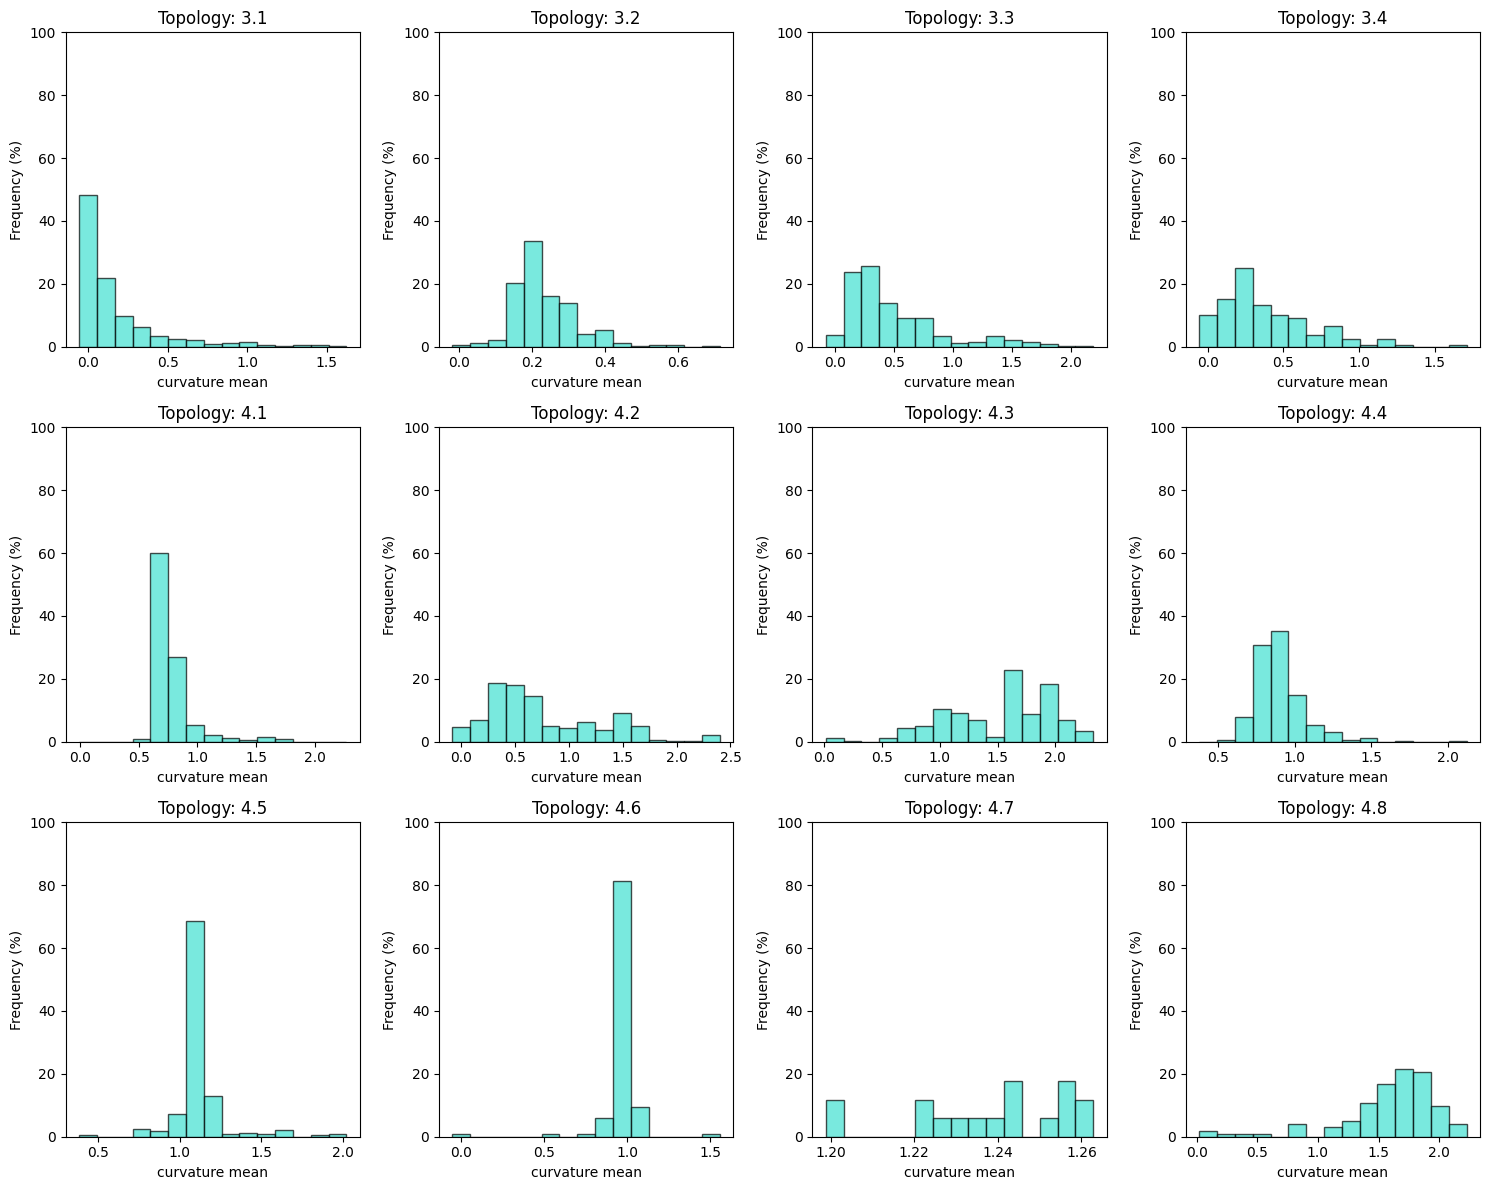

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the natural proteins data
natural_file = '/home/zarifa/Desktop/geometry_plotting/natural_rep.csv'
natural_df = pd.read_csv(natural_file)

# Strip any whitespace from column names to ensure consistency
natural_df.columns = natural_df.columns.str.strip()

# Convert relevant columns to numeric, coercing any non-numeric values to NaN
natural_df['curv_mean'] = pd.to_numeric(natural_df['curv_mean'], errors='coerce')
natural_df['CTFC'] = natural_df['CTFC'].astype(str)  # Convert 'CTFC' to string for consistent filtering

# Drop rows with NaN values in 'pitch_sign_mean' or 'pitch_sign_std'
natural_df.dropna(subset=['curv_mean'], inplace=True)

# Filter out rows where 'CTFC' is NaN, '2.1', or '2.2'
natural_df = natural_df[~natural_df['CTFC'].isin(['nan', '2.1', '2.2'])]
natural_df = natural_df[~natural_df['CTFC'].str.startswith('5')]

# Extract the first two components of the CTFC value (e.g., "3.3" from "3.3.1.4")
natural_df['CTFC_group'] = natural_df['CTFC'].apply(lambda x: '.'.join(x.split('.')[:2]))

# Group by the new CTFC_group
groups = natural_df.groupby('CTFC_group')

# Determine the number of subplots needed
num_groups = len(groups)
cols = 4  # Number of columns in the grid
rows = (num_groups + cols - 1) // cols  # Calculate rows based on the number of groups and columns

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
axes = axes.flatten()  # Flatten to easily index each subplot

# Plot each group in a separate subplot as a normalized histogram
for i, (name, group) in enumerate(groups):
    # Calculate frequencies as percentages manually
    counts, bin_edges = np.histogram(group['curv_mean'], bins=15)
    total = counts.sum()
    percentages = (counts / total) * 100  # Convert counts to percentage of total

    # Plot as a bar plot
    axes[i].bar(bin_edges[:-1], percentages, width=np.diff(bin_edges), color='turquoise', alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Topology: {name}')
    axes[i].set_xlabel('curvature mean')
    axes[i].set_ylabel('Frequency (%)')
    axes[i].set_ylim(0, 100)  # Set y-axis to a maximum of 100%

# Remove any empty subplots if the number of groups does not perfectly fill the grid
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Save the figure as a single PNG file
output_path = '/home/zarifa/Desktop/geometry_plotting/topologies_3_4_curvature_mean_histogram.png'
plt.savefig(output_path, dpi=300, format='png')

# Show the figure
plt.show()


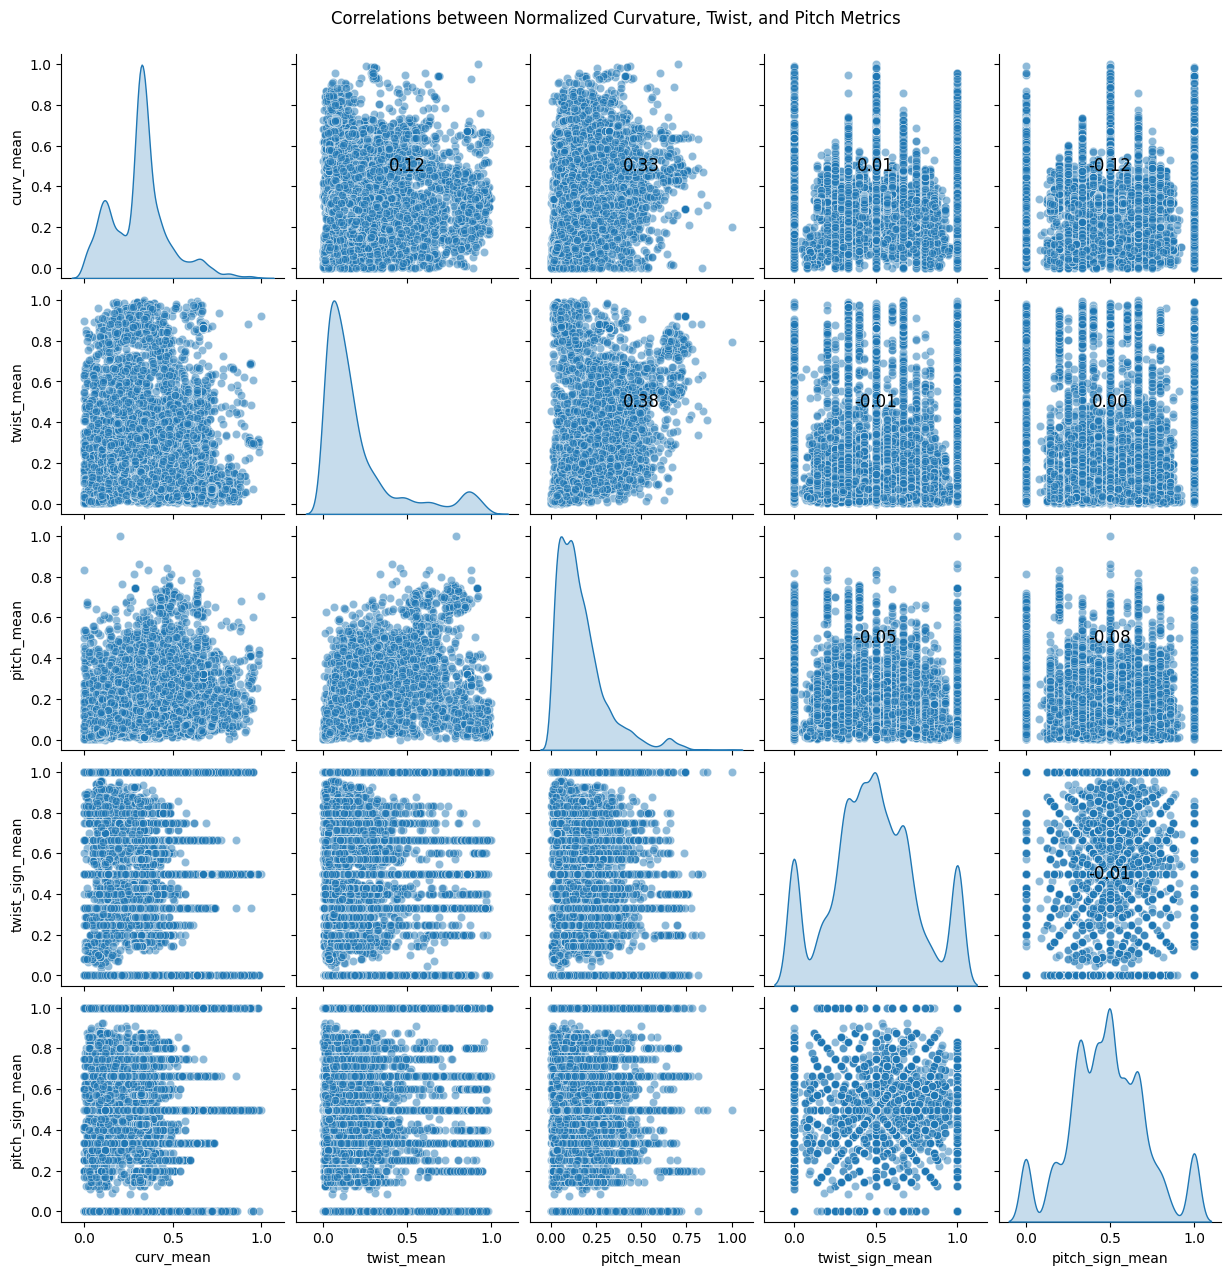

In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the natural proteins data
natural_file = '/home/zarifa/Desktop/geometry_plotting/natural_rep.csv'
natural_df = pd.read_csv(natural_file)

# Strip any whitespace from column names to ensure consistency
natural_df.columns = natural_df.columns.str.strip()

# Convert relevant columns to numeric, coercing any non-numeric values to NaN
columns_to_convert = ['curv_mean', 'twist_mean', 'pitch_mean', 'twist_sign_mean', 'pitch_sign_mean']
for col in columns_to_convert:
    natural_df[col] = pd.to_numeric(natural_df[col], errors='coerce')

# Drop rows with NaN values in the columns of interest
natural_df.dropna(subset=columns_to_convert, inplace=True)

# Normalize each column to a range of 0 to 1
scaler = MinMaxScaler()
natural_df[columns_to_convert] = scaler.fit_transform(natural_df[columns_to_convert])

# Function to display correlation coefficients on the upper triangle
def correlation_pairplot(x, y, **kwargs):
    correlation = np.corrcoef(x, y)[0, 1]
    ax = plt.gca()
    ax.annotate(f'{correlation:.2f}', xy=(0.5, 0.5), xycoords=ax.transAxes,
                ha='center', va='center', fontsize=12,
                color='red' if abs(correlation) > 0.5 else 'black')

# Create the pair plot
pair_plot = sns.pairplot(natural_df[columns_to_convert], diag_kind='kde', plot_kws={'alpha':0.5})
pair_plot.map_upper(correlation_pairplot)

# Save the plot as a PNG file before showing it
plt.suptitle("Correlations between Normalized Curvature, Twist, and Pitch Metrics", y=1.02)
plt.savefig('/home/zarifa/Desktop/geometry_plotting/correlation_natural_pairplot_normalized.png', dpi=300, format='png')

# Show plot
plt.show()



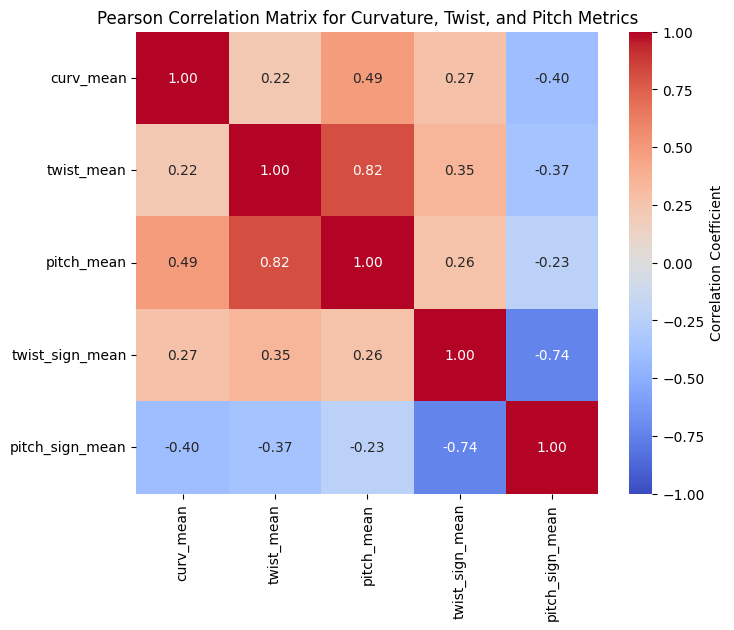

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the natural proteins data
natural_file = '/home/zarifa/Desktop/geometry_plotting/designed_c.csv'
natural_df = pd.read_csv(natural_file)

# Strip any whitespace from column names to ensure consistency
natural_df.columns = natural_df.columns.str.strip()

# Convert relevant columns to numeric, coercing any non-numeric values to NaN
columns_to_convert = ['curv_mean', 'twist_mean', 'pitch_mean', 'twist_sign_mean', 'pitch_sign_mean']
for col in columns_to_convert:
    natural_df[col] = pd.to_numeric(natural_df[col], errors='coerce')

# Drop rows with NaN values in the columns of interest
natural_df.dropna(subset=columns_to_convert, inplace=True)

# Calculate the correlation matrix
correlation_matrix = natural_df[columns_to_convert].corr()

# Create a heatmap of the correlation matrix with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1,
            cbar_kws={'label': 'Correlation Coefficient'}, square=True)

# Add a title
plt.title("Pearson Correlation Matrix for Curvature, Twist, and Pitch Metrics")

# Save the heatmap as a PNG file
plt.savefig('/home/zarifa/Desktop/geometry_plotting/correlation_matrix_designed_heatmap.png', dpi=300, format='png')

# Show the plot
plt.show()


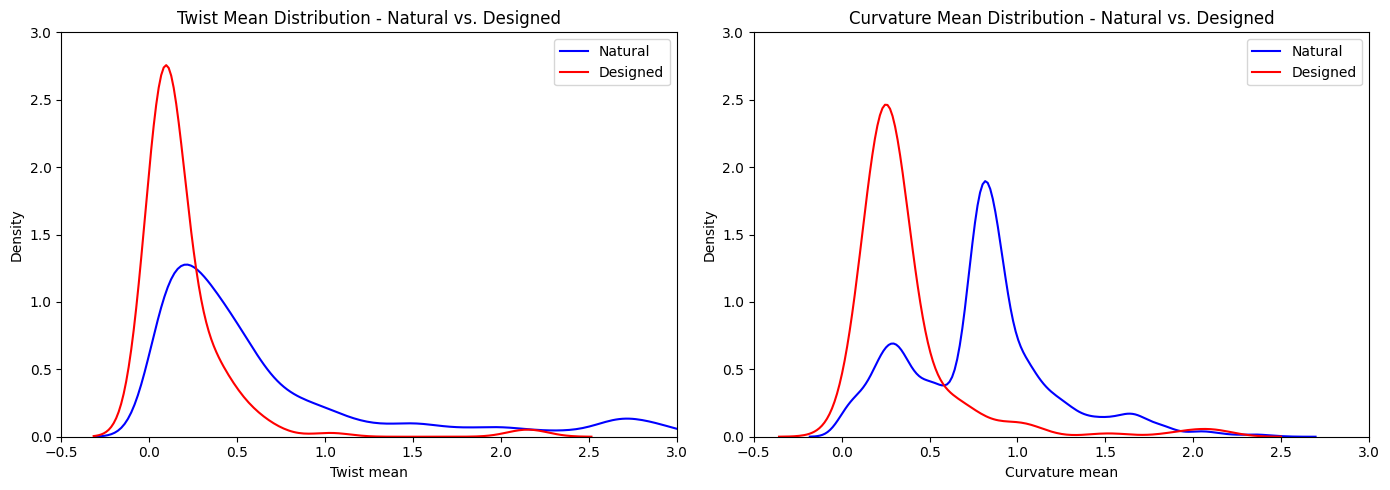

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV files
designed_file = '/home/zarifa/Desktop/geometry_plotting/designed_c.csv'
natural_file = '/home/zarifa/Desktop/geometry_plotting/natural_rep.csv'

# Load the data
filtered_designed = pd.read_csv(designed_file)
filtered_natural = pd.read_csv(natural_file)

# Calculate global min and max for twist_mean and curv_mean across both datasets
min_twist = min(filtered_natural['twist_mean'].min(), filtered_designed['twist_mean'].min())
max_twist = max(filtered_natural['twist_mean'].max(), filtered_designed['twist_mean'].max())
min_curv = min(filtered_natural['curv_mean'].min(), filtered_designed['curv_mean'].min())
max_curv = max(filtered_natural['curv_mean'].max(), filtered_designed['curv_mean'].max())

# Set the same limits for both axes across both plots without normalizing the data
x_lim = (-0.5, 3)  
y_lim = (0, 3)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Twist Handedness Comparison
sns.kdeplot(filtered_natural['twist_mean'], label='Natural', color='blue', ax=axes[0])
sns.kdeplot(filtered_designed['twist_mean'], label='Designed', color='red', ax=axes[0])
axes[0].set_xlabel('Twist mean')
axes[0].set_ylabel('Density')
axes[0].set_title('Twist Mean Distribution - Natural vs. Designed')
axes[0].legend()
axes[0].set_xlim(x_lim)
axes[0].set_ylim(y_lim)

# Curvature Handedness Comparison
sns.kdeplot(filtered_natural['curv_mean'], label='Natural', color='blue', ax=axes[1])
sns.kdeplot(filtered_designed['curv_mean'], label='Designed', color='red', ax=axes[1])
axes[1].set_xlabel('Curvature mean')
axes[1].set_ylabel('Density')
axes[1].set_title('Curvature Mean Distribution - Natural vs. Designed')
axes[1].legend()
axes[1].set_xlim(x_lim)
axes[1].set_ylim(y_lim)

# Adjust layout
plt.tight_layout()

# Save the figure as a PNG with 300 DPI
plt.savefig('/home/zarifa/Desktop/geometry_plotting/kdeplot_curvature_twist_mean_all.png', dpi=300, format='png')

# Display the plots
plt.show()


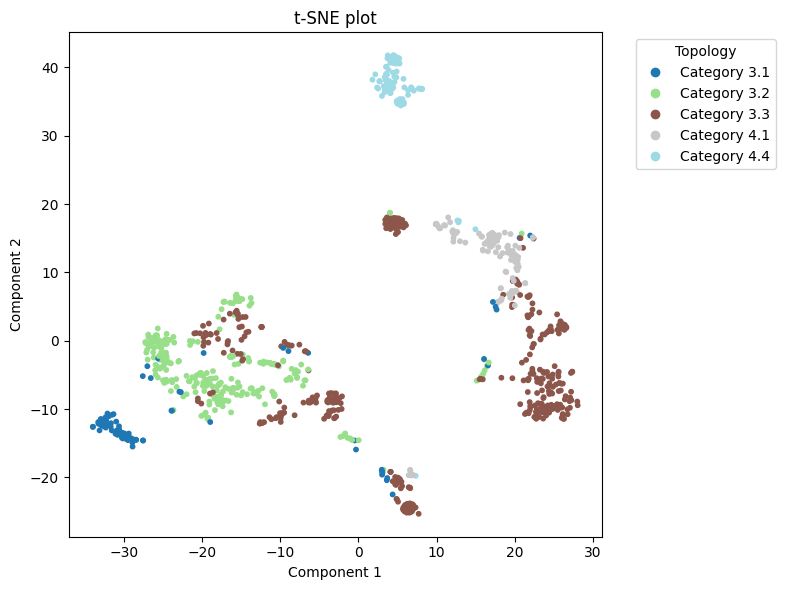

In [47]:
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Load the dataset
file_path = '/home/zarifa/Desktop/papers/Geometry/scripts/perfect_and_natural_repeats/rpeatparam_data_Geometry_rep.tsv'
data = pd.read_csv(file_path, sep='\t')

# Step 2: Clean up column names
data.columns = data.columns.str.strip()  # Remove extra whitespace from column names

# Step 3: Filter out rows where CTFC starts with '2', '4', or '5'
data = data[~data['CTFC'].astype(str).str.startswith(('2','3.4','4.6','4.7','5'))]

# Step 4: Extract the first two characters from the CTFC column
data['CTFC_category'] = data['CTFC'].astype(str).str[:3]  # Take the first two characters (e.g., "3.2")

# Step 5: Remove rows with NaN or invalid CTFC values
data = data.dropna(subset=['CTFC'])  # Remove rows where CTFC_category is NaN

# Step 6: Select numerical columns for t-SNE
numerical_columns = [
    "curv_mean", "curv_std", "twist_mean", "twist_std",
    "pitch_mean", "pitch_std"
]
numerical_data = data[numerical_columns]

# Step 7: Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(numerical_data)

# Step 8: Apply t-SNE for dimensionality reduction to 2D
tsne = TSNE(n_components=2, perplexity=50, n_iter=3000, random_state=40)
tsne_result = tsne.fit_transform(normalized_data)

# Step 9: Map unique categories to colors
# Assign indices to unique categories in a sorted order
unique_categories = sorted(data['CTFC_category'].unique(), key=lambda x: (x[0], float(x[2:])))
category_to_color = {category: idx for idx, category in enumerate(unique_categories)}

# Map categories to colors
point_colors = data['CTFC_category'].map(category_to_color).astype(int)

# Step 10: Visualize the t-SNE results with category-based coloring
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    tsne_result[:, 0], tsne_result[:, 1],
    c=point_colors, cmap='tab20', s=10
)

# Add a legend
handles = [
    plt.Line2D(
        [0], [0],
        marker='o',
        color=plt.cm.tab20(idx / max(point_colors)),
        linestyle='',
        label=f"Category {cat}"
    )
    for cat, idx in category_to_color.items()
]

plt.legend(handles=handles, title="Topology", bbox_to_anchor=(1.05, 1), loc='upper left')

# Finalize the plot
plt.title("t-SNE plot")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()
plt.savefig('/home/zarifa/Desktop/papers/Geometry/scripts/perfect_and_natural_repeats/t-sne_plot_repeatparam.png', dpi=300, format='png')
plt.show()

